# Example: 1D Oscillator - Part 2/4

- Author: Dr. Daning Huang
- Date: 07/14/2025
- Updated: 12/08/2025

After Part 1 of this example, the basic workflow of `DyMAD` should be clear.  But as we have seen, a basic model with a basic optimizer did not give satisfactory prediction accuracy.

Next, let's explore different models (LDM in Part 1 vs bilinear models) and different optimizers (NODE in Part 1 vs weak form).

## Preparation

To start with, let's import the necessary modules, which should be familiar now given Part 1.

In [1]:
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import LDM, KBF   # Added bilinear model
from dymad.training import NODETrainer, WeakFormTrainer   # Added weak form
from dymad.utils import plot_summary, plot_trajectory, TrajectorySampler

Just in case, regenerate the necessary data again.

In [2]:
B = 128   # Number of trajectories
N = 501   # Number of steps
t_grid = np.linspace(0, 5, N)

A = np.array([
            [0., 1.],
            [-1., -0.1]])
def f(t, z, u):               # Define the dynamics
    return (z @ A.T) + u
g = lambda t, z, u: z         # Define the observation

# Chirp input for training
config_chr = {
    "control" : {
        "kind": "chirp",
        "params": {
            "t1": 4.0,
            "freq_range": (0.5, 2.0),
            "amp_range": (0.5, 1.0),
            "phase_range": (0.0, 360.0)}}}

# Random Gaussian input for testing/generalization
config_gau = {
    "control" : {
        "kind": "gaussian",
        "params": {
            "mean": 0.5,
            "std":  1.0,
            "t1":   4.0,
            "dt":   0.2,
            "mode": "zoh"}}}

# Generate data
sampler_chr = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_chr)
ts, zs, us, xs = sampler_chr.sample(t_grid, batch=B, save='./data/lti.npz')

sampler_gau = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_gau)

## Weak Form Optimizer

Let's first explore how the weak form optimizer can improve the training of the previous model in Part 1.

The old case file `lti_model.yaml` is for NODE.  The NODE related part reads,

In [3]:
opt_nd = {
    "model": {
      "name" : 'lti_ldm_node',
      "encoder_layers" : 0,
      "processor_layers" : 1,
      "decoder_layers" : 0,
      "latent_dimension" : 32,
      "activation" : "none",
      "weight_init" : "xavier_uniform",
      "input_order" : "cubic"
    },
    "training" : {
      "n_epochs": 500,
      "save_interval": 10,
      "load_checkpoint": False,
      "learning_rate": 1e-3,
      "decay_rate": 0.999,
      "sweep_lengths": [50, 100, 200, 300, 501],
      "sweep_epoch_step": 100,
      "ode_method": "dopri5",
      "ode_args": {
        "rtol": 1.e-7,
        "atol": 1.e-9
      }
}}

To use weak form, we just need to replace the options.  One can see that most options remain the same.

For the weak form parameters, see the relevant documentation.

In [4]:
opt_wf = {
    "model": {
      "name" : 'lti_ldm_wf',
      "encoder_layers" : 0,
      "processor_layers" : 1,
      "decoder_layers" : 0,
      "latent_dimension" : 32,
      "activation" : "none",
      "weight_init" : "xavier_uniform",
      "input_order" : "cubic"
    },
    "training" : {
      "n_epochs": 500,
      "save_interval": 10,
      "load_checkpoint": False,
      "learning_rate": 5e-3,
      "decay_rate": 0.999,
      "weak_form_params": {
        "N": 13,
        "dN": 2,
        "ordpol": 2,
        "ordint": 2}
}}

Next, we can train the model.  For completeness, the training is done for both optimizers.

If you note the file structure, there will be two folders, 

In [5]:
config_path = 'lti_model.yaml'
trainers = [NODETrainer, WeakFormTrainer]
opts = [opt_nd, opt_wf]

for _i in range(2):
    trainer = trainers[_i](config_path, LDM, config_mod=opts[_i])
    trainer.train()

Then compare the training history.  Weak form is way faster to train than the NODE.

While the weak form loss appears to be flat, the trajectory error keeps dropping.

Epoch time NODE/WF: 43.05218453928502


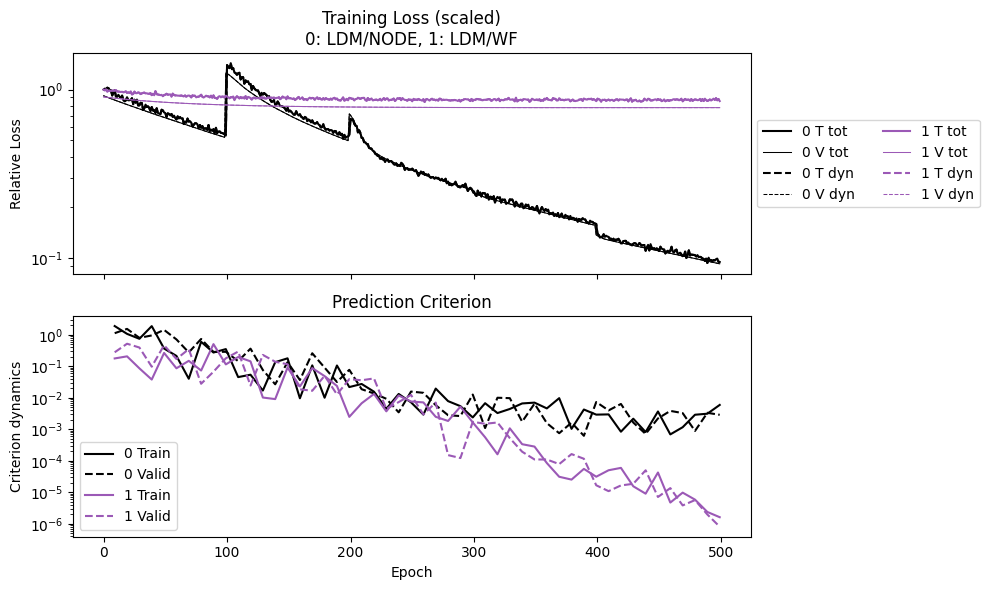

In [6]:
npz_files = ['lti_ldm_node', 'lti_ldm_wf']
npzs = plot_summary(npz_files, labels = ['LDM/NODE', 'LDM/WF'], ifclose=False)

print("Epoch time NODE/WF:", npzs[0]['avg_epoch_time']/npzs[1]['avg_epoch_time'])

And we can compare the predictions like in Part 1.  Weak form also produces a more accurate model.

In [7]:
ts, xs, us, ys = sampler_gau.sample(t_grid, batch=1, save=None)
x_data = xs[0]
t_data = ts[0]
u_data = us[0]

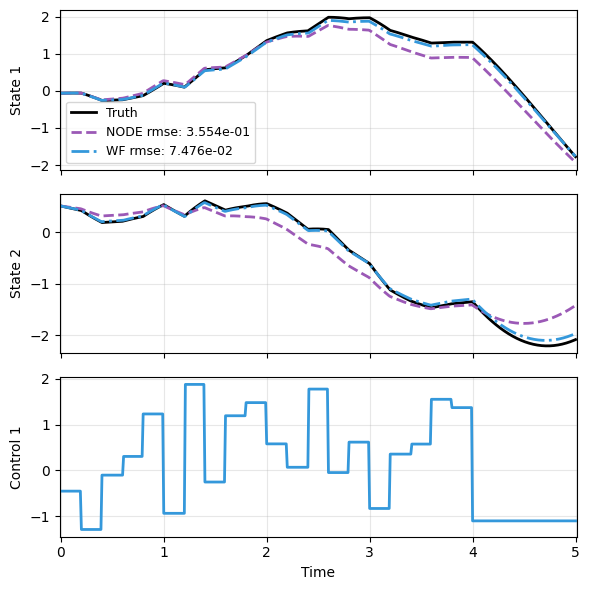

In [14]:
mdl_nd, prd_nd = load_model(LDM, 'lti_ldm_node.pt')
mdl_wf, prd_wf = load_model(LDM, 'lti_ldm_wf.pt')

with torch.no_grad():
    node_pred = prd_nd(x_data, t_data, u=u_data)
    weak_pred = prd_wf(x_data, t_data, u=u_data)

plot_trajectory(
    np.array([x_data, node_pred, weak_pred]), t_data, "LTI",
    us=u_data, labels=['Truth', 'NODE', 'WF'], ifclose=False);

## Bilinear Model

In the latent dynamics model, we had

$$
\begin{align*}
z &= h(x, u) \\
\dot{z} &= f(z, u) \\
x &= g(z, u)
\end{align*}
$$

where $h$ and $g$ are encoder and decoder, respectively, and $f$ is dynamics.

The bilinear model makes $f$ simpler as
$$
\dot{z} = Az + \sum_{i=1}^U (B_iz)u_i + B_0 u
$$
where the $B_i$'s are the additional bilinear terms.

The bilinear model has a Koopman interpretation, as well as a geometric control interpretation.

To use the KBF model, we update the model parameters in the dictionary.  In addition, the models are renamed to differentiate from the previous models.

In [9]:
opt_nd["model"] = {
      "name" : 'lti_kbf_node',
      "encoder_layers" : 1,
      "decoder_layers" : 1,
      "latent_dimension" : 32,
      "koopman_dimension" : 4,
      "const_term" : True,
      "activation" : "none",
      "weight_init" : "xavier_uniform",
      "input_order" : "cubic"
    }
opt_wf["model"] = {
      "name" : 'lti_kbf_wf',
      "encoder_layers" : 1,
      "decoder_layers" : 1,
      "latent_dimension" : 32,
      "koopman_dimension" : 4,
      "const_term" : True,
      "activation" : "none",
      "weight_init" : "xavier_uniform",
      "input_order" : "cubic"
    }

Furthermore, since now there are autoencoder layers, we need to ensure the encoder-decoder process recovers the states.  To do so, we add a reconstruction loss.  This is done through a new `criterion` entry

In [10]:
crit = {
        "dynamics" : {"weight" : 1.0},
        "recon" : {"weight" : 1.0}}
opt_nd["criterion"] = crit
opt_wf["criterion"] = crit

Then the rest is to change `LDM` to `KBF`.

In [11]:
config_path = 'lti_model.yaml'
trainers = [NODETrainer, WeakFormTrainer]
opts = [opt_nd, opt_wf]

for _i in range(2):
    trainer = trainers[_i](config_path, KBF, config_mod=opts[_i])
    trainer.train()

Again we see similar computational advantage for NODE vs KBF.

Furthermore, because now we use two losses, the history also shows how the two losses drop over time.  In the end, it appears reconstruction loss reaches nearly machine precision, and the total loss is dominated by the error in the dynamics.

Epoch time NODE/WF: 25.11939228844009


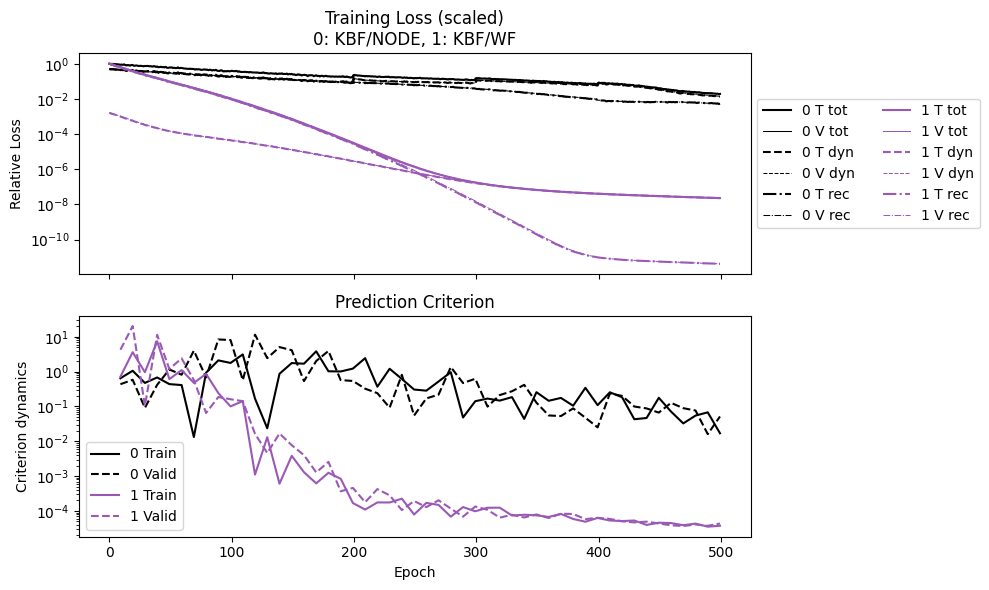

In [12]:
npz_files = ['lti_kbf_node', 'lti_kbf_wf']
npzs = plot_summary(npz_files, labels = ['KBF/NODE', 'KBF/WF'], ifclose=False)

print("Epoch time NODE/WF:", npzs[0]['avg_epoch_time']/npzs[1]['avg_epoch_time'])

... as well as improved prediction performance.

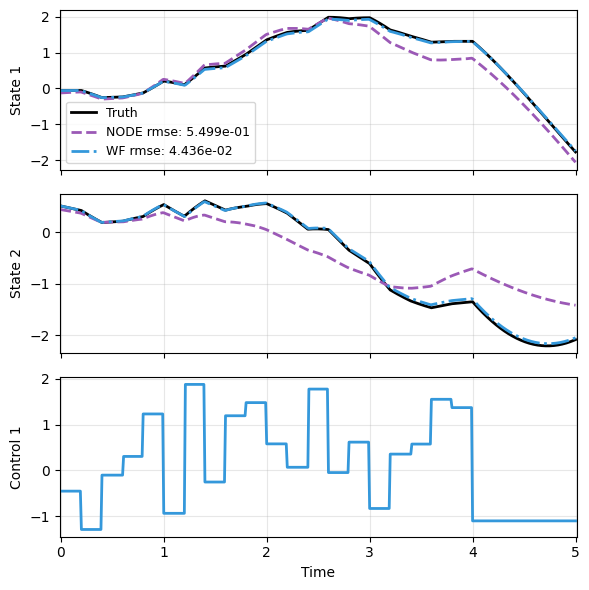

In [15]:
mdl_nd, prd_nd = load_model(KBF, 'lti_kbf_node.pt')
mdl_wf, prd_wf = load_model(KBF, 'lti_kbf_wf.pt')

with torch.no_grad():
    node_pred = prd_nd(x_data, t_data, u=u_data)
    weak_pred = prd_wf(x_data, t_data, u=u_data)

plot_trajectory(
    np.array([x_data, node_pred, weak_pred]), t_data, "LTI",
    us=u_data, labels=['Truth', 'NODE', 'WF'], ifclose=False);

## More about criteria

The criteria are what we use to optimize and select models.  For example, in the above KBF case we used

In [ ]:
"""
criterion:
  dynamics:
    weight: 1.0
  recon:
    weight: 1.0
"""

By default, it assumes the following setup, using mean squared error (`mse`) for both predicted dynamics and reconstructed observations.

In [ ]:
"""
criterion:
  dynamics:
    type: 'mse'
    weight: 1.0
    params:
      reduction: 'mean'
  recon:
    type: 'mse'
    weight: 1.0
    params:
      reduction: 'mean'
"""

When the `criterion` entry is not specified, the training will only use dynamics loss.

For other types of error, such as weighted mean squared error (WMSE) and valid prediction time (VPT), see `dymad::losses`.